In [1]:
import pandas as pd
import numpy as np
import time 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import shap
from sklearn.model_selection import ShuffleSplit

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
test.global_category.value_counts()

CAMERA             3401
AUDIO              3262
HOME AUTOMATION    3056
Name: global_category, dtype: int64

In [4]:
train.global_category.value_counts()

HOME AUTOMATION    14275
AUDIO              14258
CAMERA             13932
Name: global_category, dtype: int64

In [5]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['device','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['device','interaction_type','command'])

In [6]:
x_train, y_train = train.drop(columns=['global_category']), train['global_category']
x_test, y_test = test.drop(columns=['global_category']), test['global_category']

In [7]:
#Filas y columnas de cada conjunto:
print(f'X_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (42465, 41)
y_train : (42465,)
X_test : (9719, 41)
y_test : (9719,)


In [ ]:
#Para no usar cross validation(Tarda mucho y ofrece peores resultados)
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# RANDOM FOREST

## Sin hiperparámetros:

In [8]:
RF_model = RandomForestClassifier()

In [56]:
start = time.time()
RF_model.fit(x_train, y_train)
stop = time.time()

In [57]:
print(f"RF Execution time: {stop - start}s")
print(f'Train accuracy : {RF_model.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model.score(x_test, y_test): .3f}')

RF Execution time: 5.207667350769043s
Train accuracy :  1.000
Test accuracy :  0.535


# Eligiendo hiperparámetros mediante GridSearchCV: (TARDA MUCHO)

In [27]:
# Número de árboles
n_estimators = [int(x) for x in np.linspace(start=1, stop=150, num=15)]
# Criterio de creación de los árboles. Es la función que mide la calidad de las particiones.
criterion = ["gini", "entropy"]
# Número de características a tener en cuenta para cada árbol.
max_features = ['auto', 'sqrt', 'log2', None]
# Mínimo número de muestras que se requieren para dividir un nodo.
min_samples_split = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
# Mínimo número de muestras que se requieren en cada hoja.
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
#Número de niveles de los árboles
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)]

# True -> Muestreo Aleatorio
# False -> Se utiliza el dataset entero para construir cada árbol
bootstrap = [True, False]
# (Out of the bag) Datos que NO vamos a usar para el muestreo. Al activar esto, se usarán dichos datos para testear los árboles
# Solo disponible si bootstrap es True
oob_score = [True, False]
# True -> Reutiliza la solución de la llamada anterior para el fit y para agrefar más estimadores al conjunto.
# False -> Realiza un bosque completamente nuevo.
warm_start = [True, False]
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)]

In [51]:
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              #'bootstrap': bootstrap,
              #'oob_score': oob_score,
              #'warm_start': warm_start,
              'max_depth': max_depth}

print(param_grid)

{'n_estimators': [1, 11, 22, 32, 43, 54, 64, 75, 86, 96, 107, 118, 128, 139, 150], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


In [ ]:
RF_grid = GridSearchCV(estimator = RF_model, param_grid = param_grid, cv = cv, 
                       verbose=2, n_jobs = 4)

In [ ]:
start = time.time()
RF_grid.fit(x_train, y_train)
stop = time.time()

In [ ]:
RF_Grid.best_params_

In [ ]:
print(f"GridSearchCV time: {stop - start}s")
print(f'Train accuracy : {RF_Gid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_Grid.score(x_test, y_test): .3f}')

# Eligiendo hiperparámetros con RandomizedSearchCV:

In [63]:
RF_RandomGrid = RandomizedSearchCV(estimator = RF_model,
                                   param_distributions = param_grid,
                                   cv = 5, verbose=2, n_jobs = 4)

In [64]:
start = time.time()
RF_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [65]:
RF_RandomGrid.best_params_

{'n_estimators': 32,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': None,
 'max_depth': 8,
 'criterion': 'entropy'}

In [66]:
print(f"RandomizedSearch RF time: {stop - start}s")
print(f'Train accuracy : {RF_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_RandomGrid.score(x_test, y_test): .3f}')

RandomizedSearch RF time: 41.91151571273804s
Train accuracy :  0.999
Test accuracy :  0.789


In [67]:
RF_model4 = RandomForestClassifier(n_estimators=32,
                                   criterion='entropy',
                                   min_samples_split=7, 
                                   min_samples_leaf=3,
                                   max_features=None,
                                   max_depth = 8)
#11
start = time.time()
RF_model4.fit(x_train, y_train)
stop = time.time()

In [68]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model4.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model4.score(x_test, y_test): .3f}')

RF training time: 8.346778869628906s
Train accuracy :  0.999
Test accuracy :  0.789


# Manual:

In [135]:
RF_model4 = RandomForestClassifier(n_estimators=32,
                                   criterion='gini',
                                   min_samples_split=7, 
                                   min_samples_leaf=3,
                                   max_features=None,
                                   max_depth = 5)
#11
start = time.time()
RF_model4.fit(x_train, y_train)
stop = time.time()

In [136]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model4.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model4.score(x_test, y_test): .3f}')

RF training time: 5.5897300243377686s
Train accuracy :  0.973
Test accuracy :  0.812


## Matriz de confusión:

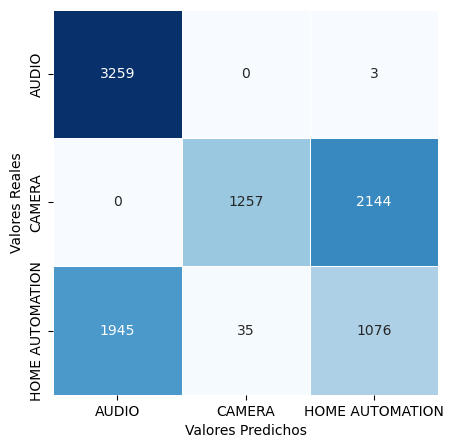

In [25]:
y_pred_RF1 = RF_model4.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF1)
class_names = ['AUDIO', 'CAMERA', 'HOME AUTOMATION']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [26]:
print(metrics.classification_report(y_test, y_pred_RF1))

                 precision    recall  f1-score   support

          AUDIO       0.63      1.00      0.77      3262
         CAMERA       0.97      0.37      0.54      3401
HOME AUTOMATION       0.33      0.35      0.34      3056

       accuracy                           0.58      9719
      macro avg       0.64      0.57      0.55      9719
   weighted avg       0.66      0.58      0.55      9719



# DECISION TREE

## Sin hiperparámetros

In [8]:
dt = DecisionTreeClassifier() #Instanciamos

start = time.time()
dt.fit(x_train, y_train)
stop = time.time()

In [105]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt.score(x_test, y_test): .3f}')

Training time: 0.4883086681365967s
Train accuracy :  1.000
Test accuracy :  0.820


In [14]:
y_pred_DT1 = dt.predict(x_test)

In [15]:
accuracy_score(y_test, y_pred_DT1)

0.8211750180059677

In [16]:
#Sacamos los parámetros de este árbol, ya que nos ha salido con buena precisión.
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Introducimos los parámetros obtenidos manualmente:

In [27]:
dt1 = DecisionTreeClassifier(criterion = 'gini', 
                             splitter='best',
                             min_samples_split = 2, 
                             min_samples_leaf = 1,
                             min_weight_fraction_leaf = 0.0,
                             min_impurity_decrease = 0.0,
                             class_weight = None,
                             max_leaf_nodes = None,
                             max_depth = 6,
                             max_features = None,
                             ccp_alpha = 0.0) #Instanciamos

#24

In [28]:
start = time.time()
dt1.fit(x_train, y_train)
stop = time.time()

In [29]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt1.score(x_test, y_test): .3f}')

Training time: 0.43483734130859375s
Train accuracy :  0.989
Test accuracy :  0.835


## Matriz de confusión:

In [30]:
y_pred_DT1 = dt1.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT1)

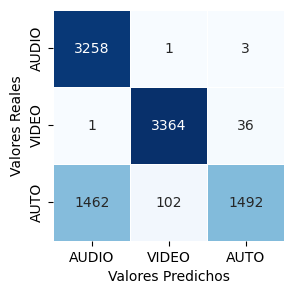

In [40]:
y_pred_DT1 = dt1.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT1)
class_names = ['AUDIO', 'VIDEO', 'AUTO']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(3, 3)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [32]:
print(metrics.classification_report(y_test, y_pred_DT1))

                 precision    recall  f1-score   support

          AUDIO       0.69      1.00      0.82      3262
         CAMERA       0.97      0.99      0.98      3401
HOME AUTOMATION       0.97      0.49      0.65      3056

       accuracy                           0.83      9719
      macro avg       0.88      0.83      0.82      9719
   weighted avg       0.88      0.83      0.82      9719



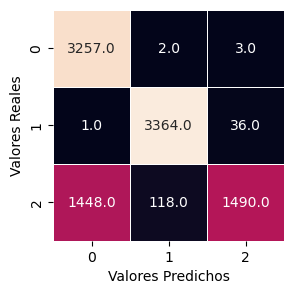

In [13]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [25]:
feature_names = x_train.columns
feature_names

Index(['L4_tcp', 'L4_udp', 'L7_http', 'L7_https', 'port_class_src',
       'port_class_dst', 'pck_size', 'ethernet_frame_size', 'ttl',
       'total_length', 'protocol', 'DNS_count', 'NTP_count', 'ARP_count',
       'cnt', 'L3_ip_dst_count', 'most_freq_prot', 'sum_et', 'min_et',
       'max_et', 'med_et', 'average_et', 'skew_et', 'kurt_et', 'var', 'q3',
       'q1', 'iqr', 'sum_e', 'min_e', 'max_e', 'med', 'average', 'skew_e',
       'kurt_e', 'var_e', 'q3_e', 'q1_e', 'iqr_e', 'inter_arrival_time',
       'time_since_previously_displayed_frame'],
      dtype='object')

In [26]:
dt1.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.82347004e-02, 9.94461332e-03, 0.00000000e+00, 1.77895635e-03,
       5.71503611e-02, 4.13851890e-04, 2.49378648e-01, 3.00057014e-01,
       7.24500867e-05, 8.16444678e-04, 9.59241988e-03, 3.28348319e-01,
       2.15741699e-03, 0.00000000e+00, 5.43417939e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.42625858e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.41998204e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.80172982e-05,
       0.00000000e+00])

In [27]:
feature_importances = pd.DataFrame(dt1.feature_importances_, index = feature_names).sort_values(0, ascending = False)
feature_importances

,0
L3_ip_dst_count,0.328348
DNS_count,0.300057
protocol,0.249379
ttl,0.057150
port_class_src,0.028235
port_class_dst,0.009945
cnt,0.009592
min_e,0.006420
min_et,0.005434
most_freq_prot,0.002157


<AxesSubplot:>

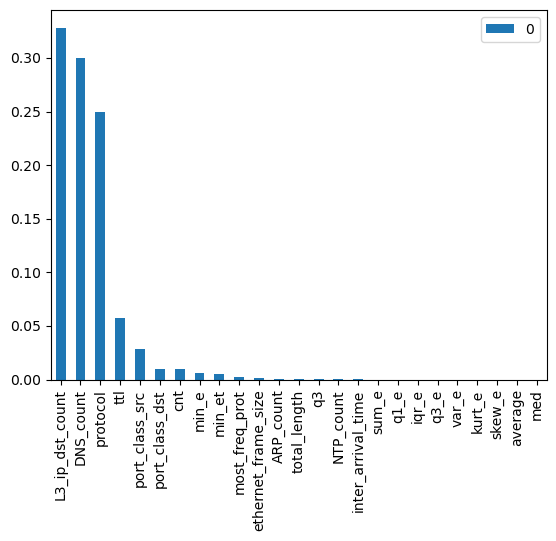

In [28]:
feature_importances.head(25).plot(kind='bar')

In [ ]:
feature_importances = pd.DataFrame(dt1.feature_importances_, index = feature_names).sort_values(0, ascending = False)
feature_importances

In [ ]:


fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt1,
                      feature_names=feature_names,
                      class_names={0:'AUDIO', 1:'CAMERA', 2:'HOME AUTOMATION'},
                      filled = True,
                      fontsize = 12)

## Árbol de decisión con las 7 propiedades de mayor peso:

In [ ]:
# Seleccionar las columnas deseadas
columnas_deseadas = ['L3_ip_dst_count', 'DNS_count', 'L4_udp', 'ttl', 'port_class_src', 'port_class_dst','global_category']
train_nuevo = train[columnas_deseadas]
test_nuevo = test[columnas_deseadas]

In [ ]:
train_nuevo

In [ ]:
x_train_n, y_train_n = train_nuevo.drop(columns=['global_category']), train_nuevo['global_category']
x_test_n, y_test_n = test_nuevo.drop(columns=['global_category']), test_nuevo['global_category']

In [ ]:
dt2 = DecisionTreeClassifier(criterion = 'gini', 
                             splitter='best',
                             min_samples_split = 2, 
                             min_samples_leaf = 1,
                             min_weight_fraction_leaf = 0.0,
                             min_impurity_decrease = 0.0,
                             class_weight = None,
                             random_state = 24,
                             max_leaf_nodes = None,
                             max_depth = None,
                             max_features = None,
                             ccp_alpha = 0.0) #Instanciamos

start = time.time()
dt2.fit(x_train_n, y_train_n)
stop = time.time()

In [ ]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt2.score(x_train_n, y_train_n): .3f}')
print(f'Test accuracy : {dt2.score(x_test_n, y_test_n): .3f}')

In [ ]:
feature_names_n = x_train_n.columns
feature_names_n

In [ ]:
fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt2,
                      feature_names=feature_names_n,
                      class_names={0:'AUDIO', 1:'CAMERA', 2:'HOME AUTOMATION'},
                      filled = True,
                      fontsize = 12)

## Eligiendo hiperparámetros con RandomizedSearchCV:

In [294]:
#Criterio de creación de los árboles. Es la función que mide la calidad de las divisiones.
criterion = ["gini", "entropy"]
#Estrategia usada para dividir los nodos
splitter = ["best", "random"]
#Mínimo número de muestras que se necesitan para dividir un nodo interno.
min_samples_split = [int(x) for x in np.linspace(start=1, stop=20, num=20)]
##Mínimo número de muestras que tiene que haber en una hoja.
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=20, num=20)]
#Número de propiedades que se usarán para llevar a cabo la mejor clasificación.
max_features = ["auto", "sqrt", None]
#Número de niveles del árbol
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)]

In [295]:
param_grid2 = {'criterion': criterion,
              'splitter': splitter,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf, 
              'max_depth': max_depth}

In [296]:
DT_RandomGrid = RandomizedSearchCV(estimator = dt, param_distributions = param_grid2, cv = 5, verbose=2, n_jobs = 4)

In [297]:
start = time.time()
DT_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [298]:
print(f"Randomized search DT time: {stop - start}s")
print(f'Train accuracy : {DT_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {DT_RandomGrid.score(x_test, y_test): .3f}')

Randomized search DT time: 5.4991090297698975s
Train accuracy :  0.999
Test accuracy :  0.781


In [299]:
DT_RandomGrid.best_params_

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'max_features': None,
 'max_depth': 9,
 'criterion': 'entropy'}

In [377]:
dt2 = DecisionTreeClassifier(criterion = 'entropy', 
                             splitter='best',
                             min_samples_split = 5, 
                             min_samples_leaf = 7,
                             max_depth = 5,
                             max_features = None) #Instanciamos

In [378]:
start = time.time()
dt2.fit(x_train, y_train)
stop = time.time()

In [379]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt2.score(x_test, y_test): .3f}')

Training time: 0.42759084701538086s
Train accuracy :  0.990
Test accuracy :  0.794


In [56]:
#Predicción
dt2.predict(x_test)

array(['AUDIO', 'AUDIO', 'AUDIO', ..., 'AUDIO', 'HOME AUTOMATION',
       'HOME AUTOMATION'], dtype=object)

In [57]:
#Niveles del árbol
dt2.get_depth()

8

## Matriz de confusión:

In [58]:
#Guardamos la predicción de Decision Tree
y_pred_DT = dt2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT)

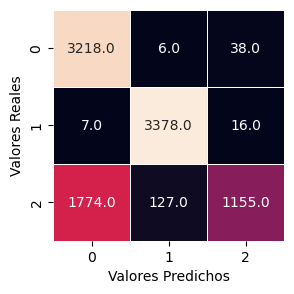

In [59]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred_DT))